In [2]:
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from ultralytics import YOLO
import psycopg2
import im_utils
import db_ops
import pandas as pd

import boto3
s3_client = boto3.client('s3')

In [3]:
import glob
from datetime import datetime
import time
import cv2

import tensorflow as tf
print(tf.__version__)

from keras.models import Model
from keras.saving import load_model

2.16.2


In [4]:
SIZE = 254 #Size of the images this model will deal with
IMDIM = 3
IMG_SIZE = (SIZE, SIZE)            # Define the image size
INPUT_SHAPE = (*IMG_SIZE, IMDIM)       # Define the input_shape

RAND_SEED  = 42 # The answer to the ultimate question of life, the universe, and everything

In [5]:
query = f'''
SELECT b.box_id AS box_id
    , b.box_pic_uri AS box_uri
	, i.image_id as image_id
	, br.brand_id as brand_id 
	, br.brand_name as brand_name 
FROM box AS b 
	LEFT JOIN brand as br
		ON b.brand_id = br.brand_id 
	LEFT JOIN image as i
		ON i.image_id = b.image_id
ORDER BY i.image_id	;
'''
box_df = db_ops.select_to_pandas(query, True, True)
box_df = box_df.sort_values(by = 'box_id')
box_df.head(3)

/home/ubuntu/workspace/litter-imagery-brand-recognition/db_ops.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


,box_id,box_uri,image_id,brand_id,brand_name
0,19074,s3://olm-processed-s3/boxes/112/Pftq4550WzgZA5...,1,304,zz_unbranded
2,19075,s3://olm-processed-s3/boxes/112/HKXafwXvrpBQjo...,2,304,zz_unbranded
3,19076,s3://olm-processed-s3/boxes/112/HKXafwXvrpBQjo...,2,304,zz_unbranded


In [5]:
# load model
model = load_model("./B0_custaug_model/B0_custaug_model.keras")

# load dataframe that correlated model index and database ID
id_idx_df = pd.read_csv('brand_ids_idx.csv', sep = '\t')

2024-07-04 02:17:02.645483: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-04 02:17:02.660003: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-04 02:17:02.663048: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

#### Read the file names and labeles

box_uri: s3://olm-processed-s3/boxes/2019/09/25/tbyHCtphOfTGUXifE0gFdNpA1Gj11sNQmAGsej4y-1238-2004-1823-2643.jpg
file_name: tbyHCtphOfTGUXifE0gFdNpA1Gj11sNQmAGsej4y-1238-2004-1823-2643.jpg
local_file_path: /home/ubuntu/temp-images/tbyHCtphOfTGUXifE0gFdNpA1Gj11sNQmAGsej4y-1238-2004-1823-2643.jpg
download: s3://olm-processed-s3/boxes/2019/09/25/tbyHCtphOfTGUXifE0gFdNpA1Gj11sNQmAGsej4y-1238-2004-1823-2643.jpg to ../../temp-images/tbyHCtphOfTGUXifE0gFdNpA1Gj11sNQmAGsej4y-1238-2004-1823-2643.jpg


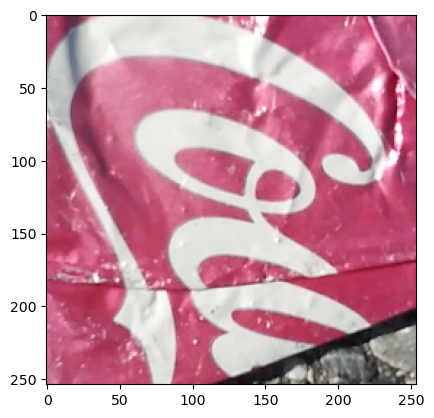

In [6]:
i = 1000

box_uri = box_df['box_uri'].iloc[i].split('.')[0] + '.jpg'
print(f"box_uri: {box_uri}")
box_id = box_df['box_id'].iloc[i]
tmp_im_folder = '/home/ubuntu/temp-images'
file_name = box_uri.split('/')[-1]
print(f"file_name: {file_name}")
local_file_path = os.path.join(tmp_im_folder, file_name)
print(f"local_file_path: {local_file_path}")

#Copy image from S3 to local folder
os.system(f"aws s3 cp {box_uri} {tmp_im_folder}") 

# Read the image
img = cv2.imread(local_file_path, cv2.IMREAD_COLOR)

#Resize the image so that the smaller side is the right size
h, w = img.shape[:2]
if h > w:
    width = SIZE
    dim = (width, int(SIZE* h / w)) 
else:
    height = SIZE
    dim = (int(SIZE* w/h), height)
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

# Crop the image to a square of the target size
h, w = img.shape[:2]
if h > w:
    img = img[(h-w)//2:(h-w)//2 + w, :, :]
else:
    img = img[:, (w-h)//2:(w-h)//2 + h, :]

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))



In [7]:
# Run the model inference on the test images
y_pred = model.predict(img.reshape(1,254,254,3))
y_pred_dense = np.argmax(y_pred, axis=1)
result = id_idx_df[id_idx_df['idx'] == y_pred_dense[0]]
result

I0000 00:00:1720059458.434103  333715 service.cc:145] XLA service 0x75f968003120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720059458.434138  333715 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-07-04 02:17:38.592032: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-04 02:17:39.207246: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


I0000 00:00:1720059463.041208  333715 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


,brand_name,count,brand_id,score,idx
43,coca_cola,135,29,3.77853,43


In [ ]:
for i in range(len(box_df)):
    try:
        print(f'---------{i}---------')
        box_uri = box_df['box_uri'].iloc[i].split('.')[0] + '.jpg'
        print(f"box_uri: {box_uri}")
        box_id = box_df['box_id'].iloc[i]
        tmp_im_folder = '/home/ubuntu/temp-images'
        file_name = box_uri.split('/')[-1]
        print(f"file_name: {file_name}")
        local_file_path = os.path.join(tmp_im_folder, file_name)
        print(f"local_file_path: {local_file_path}")
        
        #Copy image from S3 to local folder
        os.system(f"aws s3 cp {box_uri} {tmp_im_folder}") 
        
        # Read the image
        img = cv2.imread(local_file_path, cv2.IMREAD_COLOR)
        
        #Resize the image so that the smaller side is the right size
        h, w = img.shape[:2]
        if h > w:
            width = SIZE
            dim = (width, int(SIZE* h / w)) 
        else:
            height = SIZE
            dim = (int(SIZE* w/h), height)
        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        
        # Crop the image to a square of the target size
        h, w = img.shape[:2]
        if h > w:
            img = img[(h-w)//2:(h-w)//2 + w, :, :]
        else:
            img = img[:, (w-h)//2:(w-h)//2 + h, :]
        
        # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        # Run the model inference on the test images
        y_pred = model.predict(img.reshape(1,254,254,3))
        y_pred_dense = np.argmax(y_pred, axis=1)
        result = id_idx_df[id_idx_df['idx'] == y_pred_dense[0]]
        
        # Update brand id for the box we just analyzed
        query = f'''
        UPDATE box
        SET brand_id = {int(result['brand_id'].iloc[0])}
        WHERE box_id = {box_id}
        '''
        db_ops.run_single_query(query)
        os.system(f"find ~/temp-images/ -maxdepth 2 -type f -delete")
    except Exception as e:
        print(e)

---------0---------
box_uri: s3://olm-processed-s3/boxes/112/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl-792-1112-932-1416.jpg
file_name: Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl-792-1112-932-1416.jpg
local_file_path: /home/ubuntu/temp-images/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl-792-1112-932-1416.jpg
download: s3://olm-processed-s3/boxes/112/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl-792-1112-932-1416.jpg to ../../temp-images/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl-792-1112-932-1416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
---------1---------
box_uri: s3://olm-processed-s3/boxes/112/HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-612-1671-858-1884.jpg
file_name: HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-612-1671-858-1884.jpg
local_file_path: /home/ubuntu/temp-images/HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-612-1671-858-1884.jpg
download: s3://olm-processed-s3/boxes/112/HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-612-1671-858-1884.jpg to ../../temp-images/HKXafwXvrpBQjoWC9aPtSY8lTGcdoZVlPItqNQkK-

### Prepare a dataframe of filenames and labels